# Data formatting
This notebook goes through all the raster layers compiled to build the Deforestation Risk Index in Ivory Coast. It formats all layers to the same template, ensureing each pixel point for all features corresponds to the same point on the earth surface.

1. helper functions
2. time variant features:
    * Computes cell level distance to disturbances
    * Generates template for reporjection
    * reprojects disturbances to template
    * convert and export rasters to tabular format (csv)
3. time invariant features:
    * define resample operations for each feature
    * reproject each feature to the same template
    * convert each feature to a csv column, including coordinate points
4. combine al features into a unique csv:
    * Train set
    * Test set

### Main assumptions (Neeraj to review):
* transformed from binary classification problem into a regression problem by reducing resolution (from 10m to 100m)
* Projection methods for:
    * GRA_bilinear for all features except land use and forest disturbances
    * Mode for land use inventory
    * Average for binary raster of forest disturbances (yieldng a 0-1 float)


In [1]:
import rasterio
from datetime import datetime, timedelta

import numpy as np
try:
    from functools import reduce
except ImportError:
    pass

from fiona.crs import from_epsg
from shapely.geometry import Point, mapping
from fiona import collection
from fiona import transform
from osgeo import gdal, gdalconst
from os import path
import itertools
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# set pahts to data on the server
IMAGES_DATA_PATH = "/mnt/uksa-storage/guatemala/"
PREDICTIVE_MODELLING_DATA_PATH = "/home/pablo/forest_mind/analysis/data/"
# differentiate pilot (South West) and national level data
##rasters = [ 'pilot','national']
# years to consider 
years = list(range(2018,2021))


## 1. Helpers

In [3]:
#############################################
### reproject a raster to a given template ###
#############################################
def reproject_raster_to_match_template(input_file, output_file, projection_method = None, data_type = None, referencefile = "intermediate/national_template.tif"):
    if(path.isfile(output_file)):
        return

    inpt = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = inpt.GetProjection()
    inputTrans = inpt.GetGeoTransform()

    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    if data_type == None: 
        data_type = bandreference.DataType

    if projection_method == None:
        projection_method = gdalconst.GRA_Bilinear

    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(output_file,x,y,1,data_type, options = [ 'COMPRESS=LZW' ] )
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)

    gdal.ReprojectImage(inpt,output,inputProj,referenceProj,projection_method)

    del output
    
##############################
### time variant helpers ###
##############################
def distance_to_disturbance(source, target_value, outfile):
    """ Compute distance of each cell to the nearest deforested pixel"""
    cmd = f"gdal_proximity.py -co BIGTIFF=YES -co COMPRESS=LZW -maxdist 4000 -nodata 4001 -ot Int16 -values {target_value} {source} {outfile} "
    os.system(cmd)
    return

def template(source, target, resolution):
    """ Create template file at imposed respolution in meters"""
    os.system(f"rm {target}")
    cmd = f"gdalwarp -co BIGTIFF=YES -co COMPRESS=LZW -tr {resolution} {resolution} {source} {target}"
    os.system(cmd)
    return


#####################
### merge helpers ###
#####################
def create_dataset(year):
    """ Creates the columns of the tabularised data for the year and region selected"""
    year_column_path = f"intermediate/{year}.csv"
    deforestation_path = (f"intermediate/deforestation_{year}_ds.csv")  
    deforestation_path_1_lag = (f"intermediate/deforestation_{year-1}_ds.csv")  
    distance_path_1_lag = (f"intermediate/distance_to_deforestation_in_year_{year-1}_ds.csv")
    distance_path = (f"intermediate/distance_to_deforestation_in_year_{year}_ds.csv")
    output_path = f"intermediate/time_varying_{year}.csv"


    length = ! wc -l < $deforestation_path_1_lag
    command = f"yes {year} | head -n {length[0]} > {year_column_path}" #This writes out a column with given year
    ! $command\
    
    ! echo "year,deforestation_share,deforestation_share_1_lag,distance_to_deforestation,distance_to_deforestation_1_lag" > $output_path
    ! ~/.cargo/bin/xsv cat columns $year_column_path $deforestation_path $deforestation_path_1_lag $distance_path $distance_path_1_lag >> $output_path
    return

def merge_variant_invariant(year):
    """ Merges the time variant tabularised data of year with the invariant of rst region """
    os.system(f'rm output/training_{year}.csv')
    cmd = f"~/.cargo/bin/xsv cat columns intermediate/time_varying_{year}.csv output/time_invariant.csv | ~/.cargo/bin/xsv slice -s 2 | ~/.cargo/bin/xsv search -s aoi_ds 1 >> output/training_{year}.csv"
    os.system(cmd)
    return

## 2. Time variant features
### 2.1. Distance to disturbances

In [4]:
# distance to disturbances for both pilot and national EWS since 2018


for y in years:
    source = f'{IMAGES_DATA_PATH}disturbances/forest_change_by_year.tif'
    outfile = f"intermediate/distance_to_deforestation_in_year_{y}.tif" 
    target_value = y 
    distance_to_disturbance(source, target_value, outfile)
    
# 1.Takes the source raster
# 2.Uses the distance_to_disturbance() function (which uses gdal_proximity) to calculate the distance between
# each pixel and the closest target pixel, i.e. pixel which has undergone deforestation during the year. 
# 3.Target pixels have value 2018, 2019 or 2020. 
# 4. Creates a raster with distance to deforestation for all pixels. 

In [18]:
years

[2018, 2019, 2020]

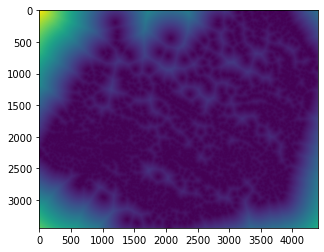

In [19]:
plt.imshow(rasterio.open("intermediate/distance_to_deforestation_in_year_2019.tif").read(1))

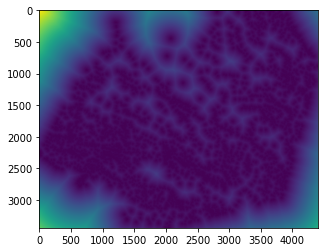

In [20]:
plt.imshow(rasterio.open("intermediate/distance_to_deforestation_in_year_2018.tif").read(1))

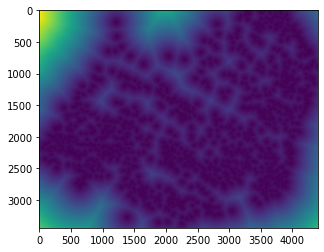

In [21]:
plt.imshow(rasterio.open("intermediate/distance_to_deforestation_in_year_2020.tif").read(1))

### 2.2. Generate template

In [22]:
# Create template file (original file is 10x10 meters, new is 100 x 100, i.e. downscale by factor of 100)


source = f'{IMAGES_DATA_PATH}disturbances/forest_change_by_year.tif'
source = f'/mnt/uksa-storage/land_cover/pilot_guatemala_aoi.tif'
target = f"intermediate/template.tif"
resolution = 20
template(source, target, resolution)

#1. Takes the source raster. 
#2. Changes the resolution of the source, from 10 x 10 to resolution x resolution. Here 20 x 20 meters. 
#3. Creates template rasters, one for each year. 

In [23]:
rasterio.open(target).bounds

BoundingBox(left=603310.0, bottom=1706700.0, right=647790.0, top=1742400.0)

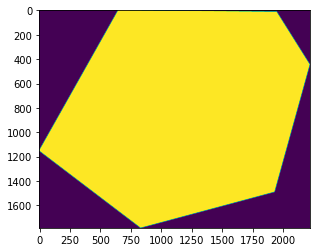

In [24]:
plt.imshow(rasterio.open(target).read(1))

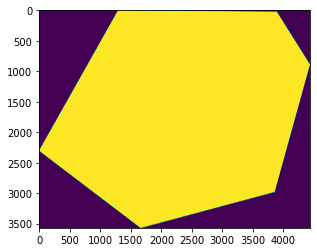

In [25]:
plt.imshow(rasterio.open(source).read(1))

### 2.3. Project to template

In [26]:
# project onto template

resample_operations = []
for y in years:
    # Deforestation history
    operation = {'input_file': f"{IMAGES_DATA_PATH}disturbances/deforestation_{y}.tif",
               'output_file': f"intermediate/deforestation_{y}_ds.tif",
               'resample_method': gdalconst.GRA_Average,
               'data_type': gdalconst.GDT_Float32}
    resample_operations.append(operation)

    # Distance to deforestation
    operation = {'input_file': f"intermediate/distance_to_deforestation_in_year_{y}.tif",
           'output_file': f"intermediate/distance_to_deforestation_in_year_{y}_ds.tif",
           'resample_method': gdalconst.GRA_Average,
           'data_type': gdalconst.GDT_Float32}
    resample_operations.append(operation)

for o in resample_operations:
    if path.isfile(o['input_file']):

        reproject_raster_to_match_template(o['input_file'], 
                                         o['output_file'], 
                                         o.get('resample_method', None),
                                         o.get('data_type', None),
                                         referencefile = f"intermediate/template.tif"  
                                         )
# Reproject_raster_to_match_template allows us to reproject our different input data (e.g. cover different areas, 
# have different crs, resolution etc) into output data that follow the template's profile. 
# 

In [15]:
resample_operations

[{'input_file': '/mnt/uksa-storage/guatemala/disturbances/deforestation_2018.tif',
  'output_file': 'intermediate/deforestation_2018_ds.tif',
  'resample_method': 5,
  'data_type': 6},
 {'input_file': 'intermediate/distance_to_deforestation_in_year_2018.tif',
  'output_file': 'intermediate/distance_to_deforestation_in_year_2018_ds.tif',
  'resample_method': 5,
  'data_type': 6},
 {'input_file': '/mnt/uksa-storage/guatemala/disturbances/deforestation_2019.tif',
  'output_file': 'intermediate/deforestation_2019_ds.tif',
  'resample_method': 5,
  'data_type': 6},
 {'input_file': 'intermediate/distance_to_deforestation_in_year_2019.tif',
  'output_file': 'intermediate/distance_to_deforestation_in_year_2019_ds.tif',
  'resample_method': 5,
  'data_type': 6},
 {'input_file': '/mnt/uksa-storage/guatemala/disturbances/deforestation_2020.tif',
  'output_file': 'intermediate/deforestation_2020_ds.tif',
  'resample_method': 5,
  'data_type': 6},
 {'input_file': 'intermediate/distance_to_deforesta

In [14]:
rasterio.open('intermediate/deforestation_2018_ds.tif').bounds

BoundingBox(left=603310.0, bottom=1706700.0, right=647790.0, top=1742400.0)

In [15]:
rasterio.open('intermediate/deforestation_2018_ds.tif').profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2224, 'height': 1785, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(20.0, 0.0, 603310.0,
       0.0, -20.0, 1742400.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

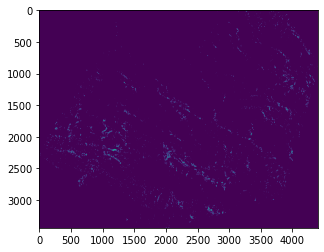

In [50]:
plt.imshow(rasterio.open(f"{IMAGES_DATA_PATH}disturbances/deforestation_2018.tif").read(1))
                         

In [49]:
np.unique(rasterio.open(f"{IMAGES_DATA_PATH}disturbances/deforestation_2018.tif").read(1), return_counts=True)

(array([0, 1], dtype=int32), array([15075363,    64077]))

In [24]:
64077/(64077+15075363)

0.0042324550974144354

In [22]:
np.unique(rasterio.open(f"intermediate/deforestation_2018_ds.tif").read(1), return_counts=True)

(array([0., 1.], dtype=float32), array([3755523,   30197]))

In [25]:
30197/(30197+3755523)

0.007976553997654344

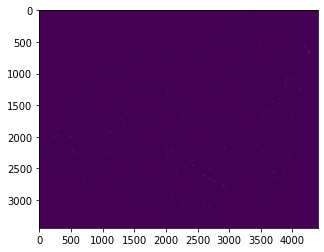

In [17]:
plt.imshow(rasterio.open('/mnt/uksa-storage/guatemala/disturbances/deforestation_2020.tif').read(1))

In [51]:
# check all bounds are the same
for i in resample_operations:
    rst = i['output_file']
    print(rasterio.open(i['input_file']).profile['height'])
    print(rasterio.open(i['output_file']).profile['height'])

    assert(rasterio.open(rst).bounds==rasterio.open(i['output_file']).bounds)
    

3440
1785
3440
1785
3440
1785
3440
1785
3440
1785
3440
1785


### 2.4. Export to csv

In [27]:
# Write out CVs with all the time variant columns
pathlist = list(Path("intermediate").glob('*_ds.tif'))

# list of time variant raster names
time_variant_stems = list(map(lambda y: f"deforestation_{y}_ds", years)) + list(map(lambda y: f"distance_to_deforestation_in_year_{y}_ds", years)) 
time_variant_paths = list(filter(lambda p: Path(p).stem  in  time_variant_stems, pathlist))
# to csv
headers = []
output_file_list = []
for i,p in enumerate(time_variant_paths):
    old_filename = str(p)
    stem = Path(p).stem 
    new_filename = stem + ".csv"


    options = "-plain"

    if(path.isfile(f"intermediate/{new_filename}")):
        print(f'continuing...{new_filename}')
        print(pd.read_csv(f'intermediate/{new_filename}').describe())
        print(np.unique(pd.read_csv(f'intermediate/{new_filename}')))

        continue

    command = f"python3 gdal2xyz.py -csv {options} {old_filename} intermediate/{new_filename}"
    print(command)
    ! $command
    


python3 gdal2xyz.py -csv -plain intermediate/deforestation_2020_ds.tif intermediate/deforestation_2020_ds.csv
python3 gdal2xyz.py -csv -plain intermediate/deforestation_2019_ds.tif intermediate/deforestation_2019_ds.csv
python3 gdal2xyz.py -csv -plain intermediate/distance_to_deforestation_in_year_2018_ds.tif intermediate/distance_to_deforestation_in_year_2018_ds.csv
python3 gdal2xyz.py -csv -plain intermediate/deforestation_2018_ds.tif intermediate/deforestation_2018_ds.csv
python3 gdal2xyz.py -csv -plain intermediate/distance_to_deforestation_in_year_2019_ds.tif intermediate/distance_to_deforestation_in_year_2019_ds.csv
python3 gdal2xyz.py -csv -plain intermediate/distance_to_deforestation_in_year_2020_ds.tif intermediate/distance_to_deforestation_in_year_2020_ds.csv


## 3. Time invariant features
### 3.1. Resample operations
Define resample operations for each feature

In [28]:
resample_operations = []

# In AOI national and pilot
cmd = f"gdal_translate -of VRT intermediate/template.tif intermediate/aoi_ds.vrt -a_nodata none"
os.system(cmd)

cmd = f'gdal_calc.py -A "intermediate/aoi_ds.vrt" --calc="A*0" --outfile="intermediate/aoi_ds.tif" --co="COMPRESS=LZW"'
os.system(cmd)

# shp with area of interest (aoi), i.e. within Guatemala border
path_to_aoi = path.join(IMAGES_DATA_PATH , "border/gtm_admbnda_adm0_ocha_conred_20190207.shp")

# rasterize the Guatemala border shp. Assign value 1 to pixels within aoi. 
cmd = f'gdal_rasterize -burn 1 {path_to_aoi} "intermediate/aoi_ds.tif"'  
os.system(cmd)
cmd  = f'rm intermediate/aoi_ds.vrt'
os.system(cmd)


0

In [29]:
resample_operations = []

aoi_operation = {'input_file': '/mnt/uksa-storage/land_cover/pilot_guatemala_aoi.tif',
                'output_file': f"intermediate/aoi_ds.tif",
                'resample_method': gdalconst.GRA_NearestNeighbour
}
resample_operations.append(aoi_operation)


In [30]:
for o in resample_operations:
    if path.isfile(o['input_file']):
        print(o)
        reproject_raster_to_match_template(o['input_file'], 
                                 o['output_file'], 
                                 o.get('resample_method', None),
                                 o.get('data_type', None),
                                 referencefile = f"intermediate/template.tif"  
                                 )


{'input_file': '/mnt/uksa-storage/land_cover/pilot_guatemala_aoi.tif', 'output_file': 'intermediate/aoi_ds.tif', 'resample_method': 0}


In [56]:
path.isfile(o['input_file'])

True

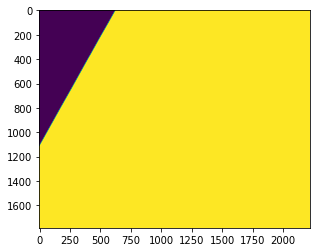

In [57]:
plt.imshow(rasterio.open('intermediate/aoi_ds.tif').read(1))

In [31]:
resample_operations = []

# AOI pilot guatemala
aoi_operation = {'input_file': '/mnt/uksa-storage/land_cover/pilot_guatemala_aoi.tif',
                'output_file': f"intermediate/aoi_ds.tif",
                'resample_method': gdalconst.GRA_NearestNeighbour
}
resample_operations.append(aoi_operation)
# Elevation. OK. 
elevation_operation = {'input_file': path.join(IMAGES_DATA_PATH, "srtm/srtm_guatemala.tif"),
                       'output_file': f"intermediate/elevation_ds.tif"}
resample_operations.append(elevation_operation)

# Slope. OK.  
slope_operation = {'input_file': path.join(IMAGES_DATA_PATH, "srtm/slope_guatemala.tif"),
                   'output_file': f"intermediate/slope_ds.tif"}
resample_operations.append(slope_operation)

# Roughness. OK.
roughness_operation = {'input_file': path.join(IMAGES_DATA_PATH, "srtm/roughness_guatemala.tif"),
                   'output_file': f"intermediate/roughness_ds.tif"}
resample_operations.append(roughness_operation)

# Ruggedness (TRI). OK. 
ruggedness_operation = {'input_file': path.join(IMAGES_DATA_PATH, "srtm/TRI_guatemala.tif"),
                       'output_file': f"intermediate/ruggedness_ds.tif"}
resample_operations.append(ruggedness_operation)

# Hansen metrics. OK. 
hansen_treecover_2000_operation = {'input_file': path.join(IMAGES_DATA_PATH, "tree_cover/Hansen_GFC-2019-v1.7_treecover2000_20N_090W.tif"),
                                   'output_file': f"intermediate/treecover_2000_ds.tif"}
resample_operations.append(hansen_treecover_2000_operation)

# Natural parks. OK. 
guatemala_parks = os.listdir(IMAGES_DATA_PATH+"parks/processed")
for park in guatemala_parks:
    park_name = park[:len(park)-4]
    park_append = {'input_file':path.join(IMAGES_DATA_PATH, f"parks/processed/{park}"),
                         'output_file': f'intermediate/{park_name}_ds.tif'}
    resample_operations.append(park_append)
        
# Merraclim metrics. OK. 
for i in range(1,19):
    merraclim_operation = {'input_file': path.join(IMAGES_DATA_PATH, f"merraclim/2_5m_mean_00s_bio{i}.tif"),
                         'output_file': f"intermediate/merraclim_{i}_ds.tif"}
    resample_operations.append(merraclim_operation)

# Distance to permanent water. OK. 
distance_to_permanent_water_operation = {'input_file': path.join(IMAGES_DATA_PATH, "rivers/distance_rivers_gtm.tif"),
                              'output_file': f"intermediate/distance_rivers_gtm_ds.tif"}
resample_operations.append(distance_to_permanent_water_operation)

# Distance to road. OK.
distance_to_road_operation = {'input_file': path.join(IMAGES_DATA_PATH, "roads/distance_roads_gtm.tif"),
                              'output_file': f"intermediate/distance_roads_gtm_ds.tif"}
resample_operations.append(distance_to_road_operation)

#Distance to urban settlement metrics. Wait for Pablo to provide filepaths. 
esa_aggregation_levels = [10,20,50,100,200]
esa_years = [2001,2006,2011,2015]
distances = []
for pair in list(itertools.product(esa_aggregation_levels, esa_years)):
    aggregation, year = pair
    distance_to_urban_settlement_operation = {'input_file': "/mnt/uksa-storage/ESA_landuse/esa_urban/distance_to_urban_cluster_over_{}_cells_year_{}.tif".format(aggregation,year),
                                              'output_file': "intermediate/distance_to_urban_cluster_over_{}_cells_year_{}_ds.tif".format(aggregation,year)
                                             }
    resample_operations.append(distance_to_urban_settlement_operation)

#Land use 2017. OK.
predominant_land_use_operation_2017 = {'input_file': path.join(IMAGES_DATA_PATH, "land_cover/2017/Smoothed/GSI_LandNow_LCC_2017_Iteration_2_Smoothed.tif"),
                                  'output_file': "intermediate/predominant_land_use_2017_ds.tif",
                                  'resample_method': gdalconst.GRA_Mode
                                  }
resample_operations.append(predominant_land_use_operation_2017)

#Land use 2020. OK.
predominant_land_use_operation_2020 = {'input_file': path.join(IMAGES_DATA_PATH, "land_cover/2020/Smoothed/GSI_LandNow_LCC_2020_Iteration_2_Smoothed.tif"),
                                  'output_file': "intermediate/predominant_land_use_2020_ds.tif",
                                  'resample_method': gdalconst.GRA_Mode
                                  }
resample_operations.append(predominant_land_use_operation_2020)

#Share closed forest 2017. 
share_closed_forest_operation = {'input_file': "/mnt/uksa-storage/land_cover/forest_mask_2017.tif",
                              'output_file': "intermediate/closed_forest_mask_2017_ds.tif"}
resample_operations.append(share_closed_forest_operation)

#Share closed forest 2017. 
share_closed_forest_operation = {'input_file': "/mnt/uksa-storage/land_cover/forest_mask_2020.tif",
                              'output_file': "intermediate/closed_forest_mask_2020_ds.tif"}
resample_operations.append(share_closed_forest_operation)

resample_operations



[{'input_file': '/mnt/uksa-storage/land_cover/pilot_guatemala_aoi.tif',
  'output_file': 'intermediate/aoi_ds.tif',
  'resample_method': 0},
 {'input_file': '/mnt/uksa-storage/guatemala/srtm/srtm_guatemala.tif',
  'output_file': 'intermediate/elevation_ds.tif'},
 {'input_file': '/mnt/uksa-storage/guatemala/srtm/slope_guatemala.tif',
  'output_file': 'intermediate/slope_ds.tif'},
 {'input_file': '/mnt/uksa-storage/guatemala/srtm/roughness_guatemala.tif',
  'output_file': 'intermediate/roughness_ds.tif'},
 {'input_file': '/mnt/uksa-storage/guatemala/srtm/TRI_guatemala.tif',
  'output_file': 'intermediate/ruggedness_ds.tif'},
 {'input_file': '/mnt/uksa-storage/guatemala/tree_cover/Hansen_GFC-2019-v1.7_treecover2000_20N_090W.tif',
  'output_file': 'intermediate/treecover_2000_ds.tif'},
 {'input_file': '/mnt/uksa-storage/guatemala/parks/processed/area_feat_parque_nacional.tif',
  'output_file': 'intermediate/area_feat_parque_nacional_ds.tif'},
 {'input_file': '/mnt/uksa-storage/guatemala/pa

### 3.2. Reproject
Compute each resample operation defined above. The computations need to be carried out twice, first for the whole country and then for the South West only.

In [32]:
for o in resample_operations:
    if path.isfile(o['input_file']):
        print(o)
        reproject_raster_to_match_template(o['input_file'], 
                                 o['output_file'], 
                                 o.get('resample_method', None),
                                 o.get('data_type', None),
                                 referencefile = f"intermediate/template.tif"  
                                 )

{'input_file': '/mnt/uksa-storage/land_cover/pilot_guatemala_aoi.tif', 'output_file': 'intermediate/aoi_ds.tif', 'resample_method': 0}
{'input_file': '/mnt/uksa-storage/guatemala/srtm/srtm_guatemala.tif', 'output_file': 'intermediate/elevation_ds.tif'}
{'input_file': '/mnt/uksa-storage/guatemala/srtm/slope_guatemala.tif', 'output_file': 'intermediate/slope_ds.tif'}
{'input_file': '/mnt/uksa-storage/guatemala/srtm/roughness_guatemala.tif', 'output_file': 'intermediate/roughness_ds.tif'}
{'input_file': '/mnt/uksa-storage/guatemala/srtm/TRI_guatemala.tif', 'output_file': 'intermediate/ruggedness_ds.tif'}
{'input_file': '/mnt/uksa-storage/guatemala/tree_cover/Hansen_GFC-2019-v1.7_treecover2000_20N_090W.tif', 'output_file': 'intermediate/treecover_2000_ds.tif'}
{'input_file': '/mnt/uksa-storage/guatemala/parks/processed/area_feat_parque_nacional.tif', 'output_file': 'intermediate/area_feat_parque_nacional_ds.tif'}
{'input_file': '/mnt/uksa-storage/guatemala/parks/processed/area_feat_parque_

### 3.3. Export to csv

In [33]:
# Write out a CSV with all the time invariant columns
# get time invariant file names
time_invariant_paths = list(Path(f"intermediate/").glob('*_ds.tif'))
headers = []
output_file_list = []
# convert each invariant file to csv
for i,p in enumerate(time_invariant_paths):
    old_filename = str(p)
    stem = Path(p).stem 
    new_filename = stem + ".csv"

    if(i == 0):
        headers.append(f"x,y,{stem}")
        print(f"first file processed is {stem}")
        options = ""
    else:
        headers.append(f"{stem}")
        options = "-plain"

    output_file_list.append(f"intermediate/{new_filename}")

    if(path.isfile(f"intermediate/{new_filename}")):
        print('continuing...')
        continue

    command = f"./gdal2xyz.py -csv {options}  {old_filename} intermediate/{new_filename}"
    print(command)
    ! $command

# create a unique csv with all variables as columns
pending = "pending.csv"
output_path = f"output/time_invariant.csv"
for i in range(len(output_file_list)):
    #print(i)
    print(output_file_list[i])
    head = headers[i]
    file = output_file_list[i]
    ! echo $head > header.csv
    ! cat  header.csv $file > append.csv
    if i ==0:
        ! cp append.csv $output_path
    else:
        ! ~/.cargo/bin/xsv cat columns append.csv $output_path > pending.csv
        ! rm $output_path
        ! mv $pending $output_path


first file processed is merraclim_7_ds
./gdal2xyz.py -csv   intermediate/merraclim_7_ds.tif intermediate/merraclim_7_ds.csv
./gdal2xyz.py -csv -plain  intermediate/area_feat_área_de_usos_múltiples_ds.tif intermediate/area_feat_área_de_usos_múltiples_ds.csv
./gdal2xyz.py -csv -plain  intermediate/area_feat_reserva_de_la_biosfera_ds.tif intermediate/area_feat_reserva_de_la_biosfera_ds.csv
./gdal2xyz.py -csv -plain  intermediate/distance_to_urban_cluster_over_50_cells_year_2001_ds.tif intermediate/distance_to_urban_cluster_over_50_cells_year_2001_ds.csv
./gdal2xyz.py -csv -plain  intermediate/merraclim_5_ds.tif intermediate/merraclim_5_ds.csv
./gdal2xyz.py -csv -plain  intermediate/roughness_ds.tif intermediate/roughness_ds.csv
./gdal2xyz.py -csv -plain  intermediate/distance_to_urban_cluster_over_100_cells_year_2015_ds.tif intermediate/distance_to_urban_cluster_over_100_cells_year_2015_ds.csv
./gdal2xyz.py -csv -plain  intermediate/merraclim_1_ds.tif intermediate/merraclim_1_ds.csv
./gda

./gdal2xyz.py -csv -plain  intermediate/closed_forest_mask_2020_ds.tif intermediate/closed_forest_mask_2020_ds.csv
./gdal2xyz.py -csv -plain  intermediate/area_feat_refugio_de_vida_silvestre_ds.tif intermediate/area_feat_refugio_de_vida_silvestre_ds.csv
./gdal2xyz.py -csv -plain  intermediate/area_feat_undefined_ds.tif intermediate/area_feat_undefined_ds.csv
./gdal2xyz.py -csv -plain  intermediate/distance_to_urban_cluster_over_50_cells_year_2011_ds.tif intermediate/distance_to_urban_cluster_over_50_cells_year_2011_ds.csv
./gdal2xyz.py -csv -plain  intermediate/merraclim_3_ds.tif intermediate/merraclim_3_ds.csv
./gdal2xyz.py -csv -plain  intermediate/predominant_land_use_2020_ds.tif intermediate/predominant_land_use_2020_ds.csv
./gdal2xyz.py -csv -plain  intermediate/slope_ds.tif intermediate/slope_ds.csv
./gdal2xyz.py -csv -plain  intermediate/distance_to_urban_cluster_over_200_cells_year_2015_ds.tif intermediate/distance_to_urban_cluster_over_200_cells_year_2015_ds.csv
intermediate/m

In [36]:
time_inv = pd.read_csv("output/time_invariant.csv")
time_inv.shape

(3785720, 80)

In [31]:
time_inv.describe()

,distance_to_urban_cluster_over_200_cells_year_2015_ds,slope_ds,predominant_land_use_2020_ds,merraclim_3_ds,distance_to_urban_cluster_over_50_cells_year_2011_ds,area_feat_undefined_ds,area_feat_refugio_de_vida_silvestre_ds,area_feat_reserva_de_uso_multiple_ds,aoi_ds,distance_rivers_gtm_ds,...,merraclim_1_ds,distance_to_urban_cluster_over_100_cells_year_2015_ds,roughness_ds,merraclim_5_ds,distance_to_urban_cluster_over_50_cells_year_2001_ds,area_feat_reserva_de_la_biosfera_ds,area_feat_área_de_usos_múltiples_ds,x,y,merraclim_7_ds
count,3.785720e+06,3.785720e+06,3.785720e+06,3.785720e+06,3.785720e+06,3785720.0,3785720.0,3785720.0,3.785720e+06,3.785720e+06,...,3.785720e+06,3.785720e+06,3.785720e+06,3.785720e+06,3.785720e+06,3785720.0,3785720.0,3.785720e+06,3.785720e+06,3.785720e+06
mean,7.793453e+04,1.901196e+01,6.739395e+00,6.179526e+01,4.687742e+04,0.0,0.0,0.0,7.522289e-01,4.204900e+01,...,2.158204e+02,4.662160e+04,8.757816e+01,3.470598e+02,7.032637e+04,0.0,0.0,6.255681e+05,1.724994e+06,2.533946e+02
std,1.014912e+04,1.022143e+01,4.587469e+00,1.806152e+00,1.146690e+04,0.0,0.0,0.0,4.317182e-01,4.202131e+01,...,7.071033e+00,1.147761e+04,5.095202e+01,8.917802e+00,9.857612e+03,0.0,0.0,1.270748e+04,9.930424e+03,4.215622e+00
min,5.617100e+04,0.000000e+00,0.000000e+00,5.900000e+01,1.808000e+04,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,1.990000e+02,1.788800e+04,1.000000e+00,3.220000e+02,5.196900e+04,0.0,0.0,6.035681e+05,1.707804e+06,2.430000e+02
25%,7.000500e+04,1.200000e+01,1.000000e+00,6.000000e+01,3.859700e+04,0.0,0.0,0.0,1.000000e+00,1.500000e+01,...,2.110000e+02,3.831200e+04,5.400000e+01,3.410000e+02,6.187700e+04,0.0,0.0,6.145681e+05,1.716399e+06,2.500000e+02
50%,7.807600e+04,1.900000e+01,1.000000e+01,6.200000e+01,4.740500e+04,0.0,0.0,0.0,1.000000e+00,3.200000e+01,...,2.160000e+02,4.711500e+04,8.300000e+01,3.480000e+02,7.032600e+04,0.0,0.0,6.255681e+05,1.724994e+06,2.540000e+02
75%,8.618500e+04,2.600000e+01,1.000000e+01,6.300000e+01,5.554100e+04,0.0,0.0,0.0,1.000000e+00,5.400000e+01,...,2.220000e+02,5.531200e+04,1.140000e+02,3.540000e+02,7.880700e+04,0.0,0.0,6.365681e+05,1.733589e+06,2.570000e+02
max,1.011790e+05,7.700000e+01,1.100000e+01,6.600000e+01,7.349600e+04,0.0,0.0,0.0,1.000000e+00,3.000000e+02,...,2.300000e+02,7.328700e+04,6.750000e+02,3.650000e+02,9.007500e+04,0.0,0.0,6.475681e+05,1.742184e+06,2.610000e+02


## 4. Merge datasets
### 4.1. Training set

In [34]:
# train datasets
for year in range(2019,2021):
    create_dataset(year)
    merge_variant_invariant(year)


yes: standard output: Broken pipe
yes: standard output: Broken pipe


In [108]:
train_2019 = pd.read_csv("output/training_2019.csv")

In [109]:
train_2019.shape

(2847728, 63)

In [102]:
train_2019.isna().sum().sum()


0

In [101]:
train_2020 = pd.read_csv("output/training_2020.csv")
train_2020.isna().sum()

year                                   0
deforestation_share                    0
deforestation_share_1_lag              0
distance_to_deforestation              0
distance_to_deforestation_1_lag        0
                                      ..
area_feat_reserva_de_la_biosfera_ds    0
area_feat_área_de_usos_múltiples_ds    0
x                                      0
y                                      0
merraclim_7_ds                         0
Length: 62, dtype: int64